# **IMPORT LIBRARY**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Split dataset
from sklearn.model_selection import train_test_split
# Standarisasi fitur
from sklearn.preprocessing import StandardScaler, LabelBinarizer
# Validasi silang
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
# Metrik evaluasi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
# Tuning parameter
from sklearn.model_selection import GridSearchCV
# XGBOOST
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# **DATA**

In [3]:
# Membaca data
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")
# Menampilkan jumlah baris dan kolom
print(data_train.shape)
print(data_test.shape)

(2000, 21)
(1000, 21)


# **EXPLORATORY DATA ANALYSIS**

In [4]:
# Menampilkan informasi data
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [5]:
# Menampilkan data awal
data_train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


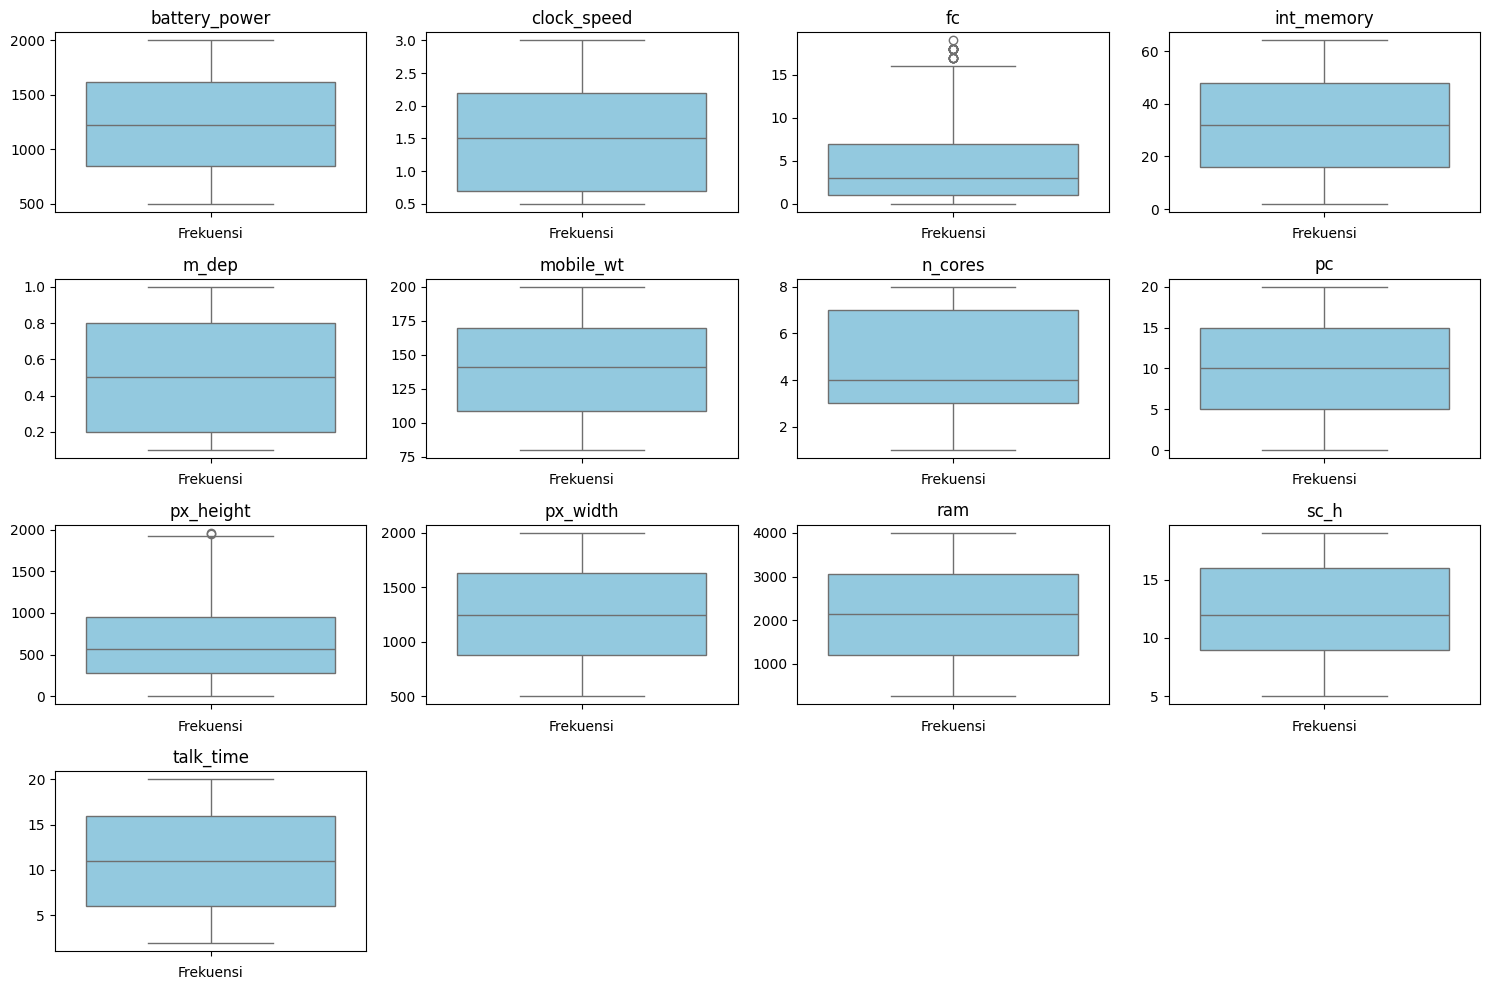

In [6]:
## Menampilkan boxplot ##
# Membuat objek gambar
plt.figure(figsize=(15,10))
# Kolom numerik
kolom_numerik = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'talk_time']
# Looping for untuk mendapatkan indeks fitur dengan nilai kolomnya
for i, column in enumerate(kolom_numerik):
  # Membuat subplot dengan ukuran 3 baris 4 kolom
  plt.subplot(4,4,i+1)
  # Membuat boxplot
  sns.boxplot(data=data_train, y=column, color='skyblue')
  # Menampilkan judul subplot
  plt.title(column, fontsize = 12)
  plt.xlabel('Frekuensi')
  plt.ylabel('')
  # Mengatur tata letak subplot
  plt.tight_layout();

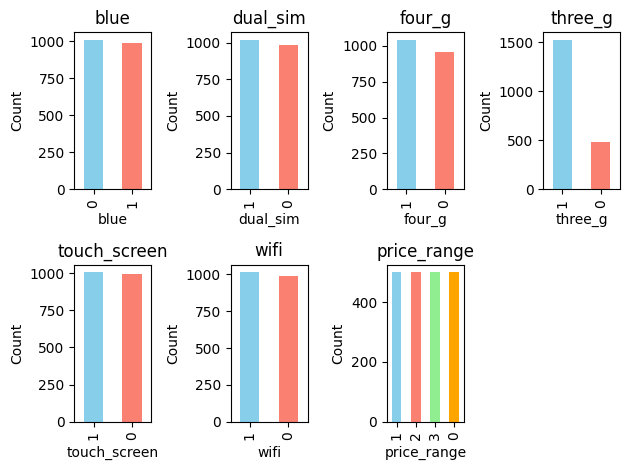

In [7]:
## Menampilkan diagram batang ##
# Kolom kategorik
kolom_kategorik = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi', 'price_range']
# Daftar warna plot
colors = ['skyblue', 'salmon', 'lightgreen', 'orange']
# Looping for untuk mendapatkan indeks fitur dengan nilai kolomnya
for i, column in enumerate(kolom_kategorik):
    plt.subplot(2, 4, i + 1)
    # Membuat diagram batang
    data_train[column].value_counts().plot(kind='bar', color=colors)
    plt.title(column, fontsize=12)
    plt.ylabel('Count')
    plt.tight_layout()

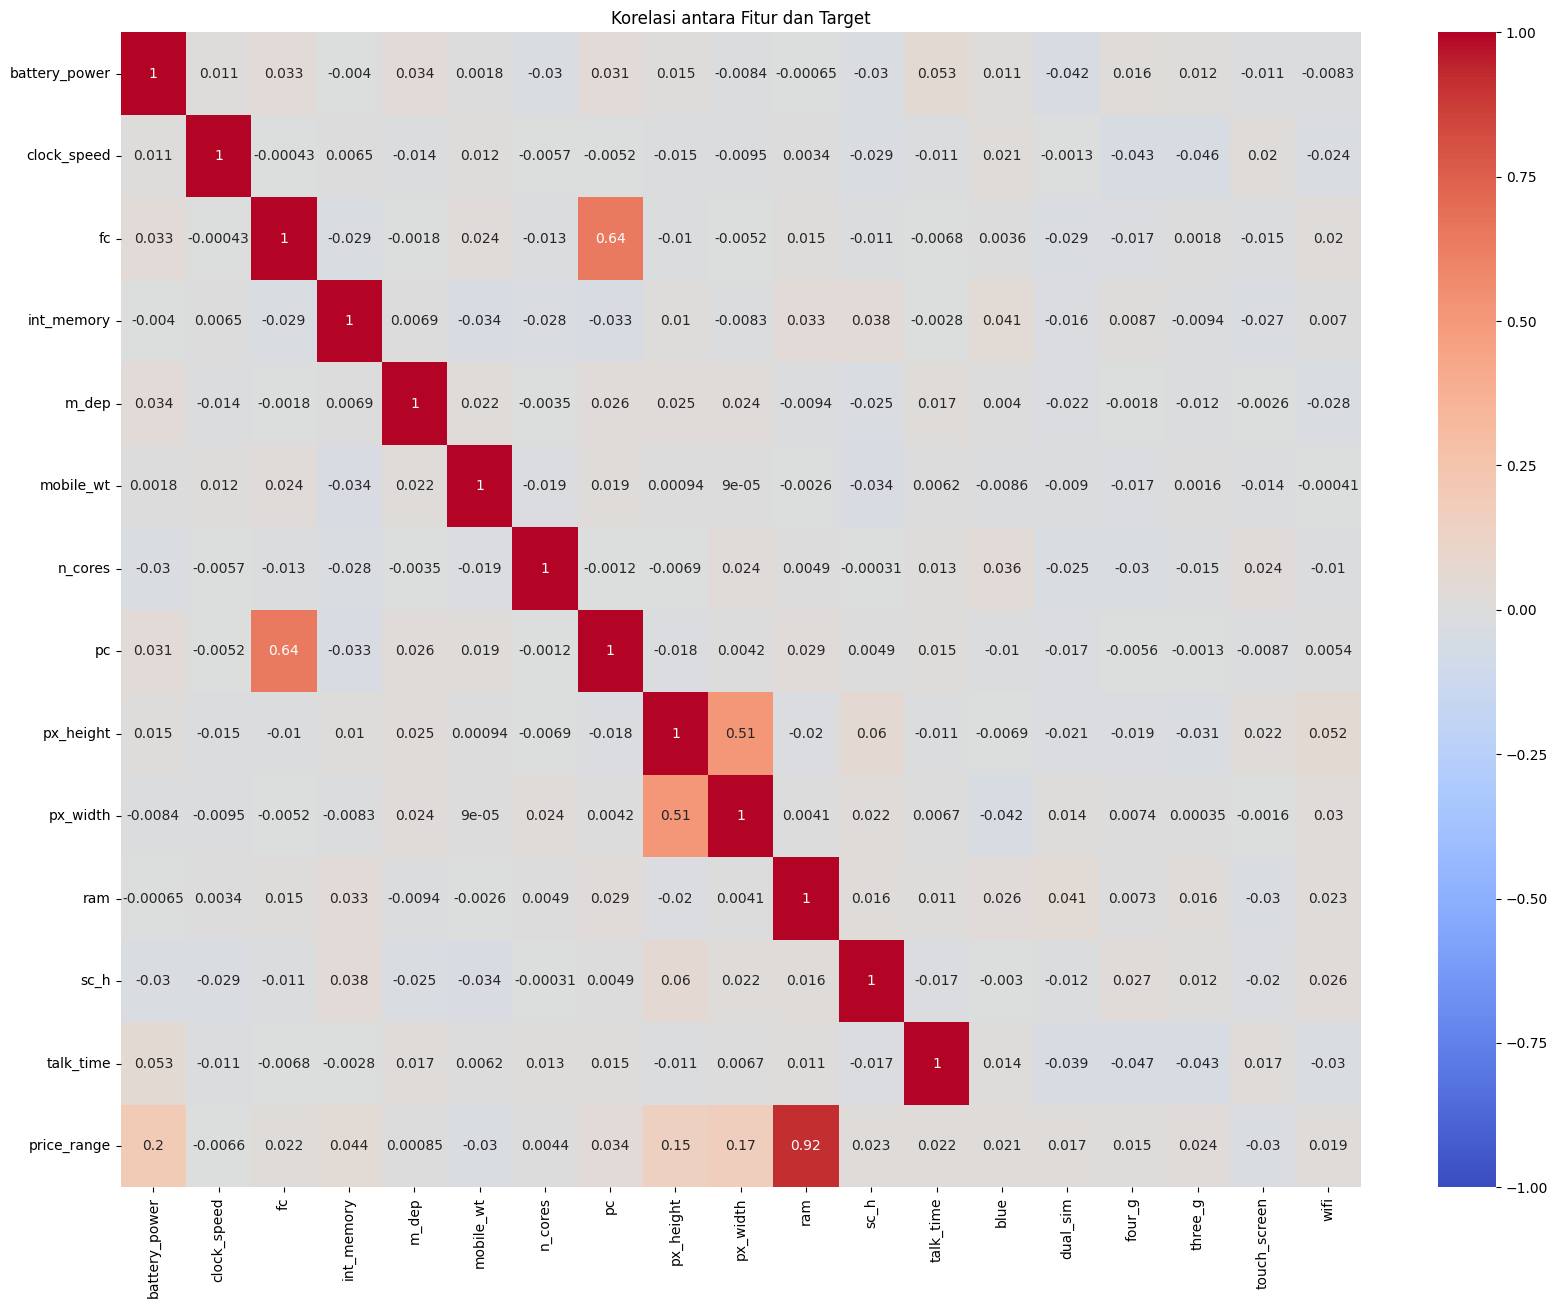

In [8]:
## Plot korelasi ##
# Daftar variabel numerik
variabel_numerik = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'talk_time']
# Daftar variabel kategorikal
variabel_kategorik = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
# Gabungan variabel
variables = variabel_numerik + variabel_kategorik
# Korelasi antara variabel numerik dan target
kor = data_train[variables + ['price_range']].corr()
# Plot heatmap dari korelasi
plt.figure(figsize=(20, 15))
# Membuat plot korelasi
sns.heatmap(kor.loc[variabel_numerik + ['price_range'], variables], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korelasi antara Fitur dan Target')
plt.show()

# **DATA PREPROCESSING**

**Standardize**

In [9]:
## Standarisasi data (mean = 0 dan st.dev = 1) ##
# Mendefinisikan fungsi scale data
def scale_data(data_train):
    # Membuat salinan data
    scaled_data_train = data_train.copy()
    # Fitur numerik yang diskalakan
    fitur_numerik = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'talk_time']
    # Melakukan standarisasi
    scaler = StandardScaler()
    # Mengubah skala nilai
    scaled_data_train[fitur_numerik] = scaler.fit_transform(scaled_data_train[fitur_numerik])
    return scaled_data_train
# Menampilkan data hasil standarisasi
scaled_data_train = scale_data(data_train)
print(scaled_data_train)

      battery_power  blue  clock_speed  dual_sim        fc  four_g  \
0         -0.902597     0     0.830779         0 -0.762495       0   
1         -0.495139     1    -1.253064         1 -0.992890       1   
2         -1.537686     1    -1.253064         1 -0.532099       1   
3         -1.419319     1     1.198517         0 -0.992890       0   
4          1.325906     1    -0.395011         0  2.002254       1   
...             ...   ...          ...       ...       ...     ...   
1995      -1.011860     1    -1.253064         1 -0.992890       1   
1996       1.653694     1     1.321096         1 -0.992890       0   
1997       1.530773     0    -0.762748         1 -0.762495       1   
1998       0.622527     0    -0.762748         0 -0.071307       1   
1999      -1.658331     1     0.585621         1  0.159088       1   

      int_memory     m_dep  mobile_wt   n_cores  ...  px_height  px_width  \
0      -1.380644  0.340740   1.349249 -1.101971  ...  -1.408949 -1.146784   
1    

**Feature Engineering**

In [10]:
# Pembuatan kolom fitur untuk masing masing kolom numerik dan kategorik
kolom_fitur = []

# Fitur Numerik:
fitur_numerik = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'talk_time']

for col in fitur_numerik:
  kolom_fitur_numerik = tf.feature_column.numeric_column(col)
  kolom_fitur.append(kolom_fitur_numerik)

# Fitur Kategorik:
fitur_kategorik = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

for col in fitur_kategorik:
    kolom_fitur_kategorik = tf.feature_column.categorical_column_with_vocabulary_list(
        key=col,
        vocabulary_list=scaled_data_train[col].unique().tolist()
    )
    kolom_fitur_kategorik_onehot = tf.feature_column.indicator_column(kolom_fitur_kategorik)
    kolom_fitur.append(kolom_fitur_kategorik_onehot)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [11]:
# Pembuatan lapisan fitur sebagai input untuk model NN
feature_layer = tf.keras.layers.DenseFeatures(kolom_fitur)

In [12]:
# Konversi dataframe ke dataset Tensorflow
def data_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('price_range')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe),labels))

  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))

  ds = ds.batch(batch_size=batch_size)

  return ds

**Split Data**

In [13]:
## Partisi Data untuk model NN ##
train, test = train_test_split(scaled_data_train, test_size=0.2, random_state=42)

In [14]:
# Konversi dataframe train dan test ke dataset tfds
train_ds = data_to_dataset(train, shuffle = True, batch_size=32)
test_ds = data_to_dataset(test, shuffle=False, batch_size=32)

In [15]:
## Split data ke dalam fitur (X) dan target (Y) ##
# Fitur X
X = scale_data(data_train.drop('price_range', axis=1))
# Target Y
y = scaled_data_train['price_range']

In [16]:
X

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,-0.902597,0,0.830779,0,-0.762495,0,-1.380644,0.340740,1.349249,-1.101971,-1.305750,-1.408949,-1.146784,0.391703,-0.784983,7,1.462493,0,0,1
1,-0.495139,1,-1.253064,1,-0.992890,1,1.155024,0.687548,-0.120059,-0.664768,-0.645989,0.585778,1.704465,0.467317,1.114266,3,-0.734267,1,1,0
2,-1.537686,1,-1.253064,1,-0.532099,1,0.493546,1.381165,0.134244,0.209639,-0.645989,1.392684,1.074968,0.441498,-0.310171,2,-0.368140,1,1,0
3,-1.419319,1,1.198517,0,-0.992890,0,-1.215274,1.034357,-0.261339,0.646842,-0.151168,1.286750,1.236971,0.594569,0.876859,8,-0.002014,1,0,0
4,1.325906,1,-0.395011,0,2.002254,1,0.658915,0.340740,0.021220,-1.101971,0.673534,1.268718,-0.091452,-0.657666,-1.022389,2,0.730240,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1.011860,1,-1.253064,1,-0.992890,1,-1.656260,1.034357,-0.967737,0.646842,0.673534,1.300273,1.477661,-1.342799,0.164641,4,1.462493,1,1,0
1996,1.653694,1,1.321096,1,-0.992890,0,0.383299,-1.046495,1.320993,-0.227564,-1.140810,0.608317,1.651235,-0.085031,-0.310171,10,0.913303,1,1,1
1997,1.530773,0,-0.762748,1,-0.762495,1,0.217930,0.687548,-0.911225,1.521249,-1.140810,0.502383,0.880565,0.860139,-0.784983,1,-1.100394,1,1,0
1998,0.622527,0,-0.762748,0,-0.071307,1,0.769162,-1.393304,0.134244,0.209639,-0.810929,-0.696707,-1.345816,-1.157454,1.351672,10,1.462493,1,1,1


In [17]:
y

0       1
1       2
2       2
3       2
4       1
       ..
1995    0
1996    2
1997    3
1998    0
1999    3
Name: price_range, Length: 2000, dtype: int64

In [18]:
## Partisi data ##
# Partisi data ke dalam data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
# Menampilkan dimensi data
print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")

X_train : (1600, 20)
X_test : (400, 20)
y_train : (1600,)
y_test : (400,)


In [19]:
X_train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
968,1.558089,0,-1.253064,1,0.619880,0,0.769162,-0.006069,1.434017,-1.539175,0.013773,0.274736,1.174484,-0.585741,-0.547577,9,-1.466521,1,1,1
240,-1.378345,1,0.830779,0,-0.992890,1,0.934531,-1.393304,-0.035292,1.521249,-1.470690,-0.261699,-0.561260,1.323964,-0.310171,1,0.913303,1,1,1
819,-0.005733,0,-0.762748,1,-0.532099,1,1.375517,-1.393304,1.349249,-1.539175,0.673534,-0.288746,-1.024125,-0.662277,0.402047,12,1.645557,1,0,1
692,-1.041452,0,-0.517590,0,-0.532099,0,0.328176,-0.352878,1.631808,0.209639,-0.481048,-0.768833,0.977767,1.276014,0.164641,8,-1.100394,0,0,1
420,0.495054,1,-1.253064,1,0.619880,0,-1.380644,-0.352878,-0.995993,0.209639,0.343653,0.400956,-0.341399,-0.495373,-1.497202,5,1.645557,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1.676457,1,0.463042,1,-0.532099,0,-0.057686,1.381165,0.303779,-1.539175,1.168355,0.292767,0.822707,0.827865,0.164641,5,1.462493,0,0,1
1294,-1.478503,1,-1.253064,0,-0.762495,1,1.485763,0.687548,0.162500,1.521249,-0.975869,0.256704,1.403602,-1.624967,0.876859,10,-0.917331,1,1,1
860,1.344116,1,-1.253064,0,-0.992890,1,-0.939658,-0.352878,0.558083,0.209639,-0.481048,0.189087,0.035836,-0.040770,0.876859,11,0.181050,1,0,1
1459,1.567194,0,-0.762748,1,-0.301703,0,-1.160151,-0.352878,1.405761,1.521249,0.343653,-0.347348,0.588960,0.730120,0.876859,11,1.279430,0,1,1


In [20]:
y_train

968     1
240     2
819     0
692     3
420     1
       ..
1130    3
1294    0
860     2
1459    3
1126    1
Name: price_range, Length: 1600, dtype: int64

In [21]:
X_test

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
1860,0.927552,0,1.198517,0,-0.301703,1,-0.388426,0.340740,1.688320,-1.101971,-0.810929,-0.978448,0.825021,-1.326201,-1.022389,6,-0.002014,1,1,0
353,-0.128653,0,-1.253064,0,0.619880,1,-1.325520,-0.006069,-0.063548,1.521249,1.003414,-0.834197,-0.614489,0.404613,1.589078,17,1.462493,1,0,0
1333,1.669628,0,1.688833,0,1.080671,0,-0.994781,-0.352878,1.575296,1.084046,1.333295,-0.793626,-0.693176,-0.745267,-1.022389,1,-0.551204,1,1,0
905,-0.567980,1,0.585621,0,-0.071307,0,-0.829411,-1.046495,0.727618,-0.664768,1.498235,-0.877022,0.329755,1.630107,1.351672,7,1.462493,1,1,0
1289,-1.419319,1,-1.253064,1,0.619880,0,1.430640,-0.006069,-0.289595,0.209639,-0.316108,0.847234,1.635035,-0.201218,0.402047,5,-1.100394,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,0.319779,0,-1.253064,1,-0.762495,0,-0.719165,-0.699686,-0.176571,1.521249,1.168355,-0.581757,-1.343502,1.648549,-0.310171,2,1.462493,0,1,1
1284,-0.563428,0,0.585621,0,-0.532099,1,-1.105027,-0.699686,0.501571,0.209639,-0.645989,1.270972,0.987024,-0.101629,-0.310171,9,-0.185077,1,0,0
1739,-0.442784,0,0.340463,0,-0.071307,1,-1.105027,0.687548,-1.024249,0.646842,-0.810929,1.318305,0.026579,-0.304495,1.351672,7,1.462493,1,1,1
261,-1.162096,0,1.443675,1,-0.992890,0,-0.388426,-1.046495,-1.476344,-0.227564,-1.470690,-0.268461,0.642189,-0.078576,-1.734608,1,0.181050,1,1,1


In [22]:
y_test

1860    0
353     2
1333    1
905     3
1289    1
       ..
965     3
1284    2
1739    1
261     1
535     2
Name: price_range, Length: 400, dtype: int64

# **MODELLING**

# **NEURAL NETWORK**

In [25]:
## Membangun Model NN ##
model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=4, activation='softmax')  # 4 kelas untuk 'price_range'
])

# Kompilasi Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Latih model
history = model.fit(train_ds, validation_data=test_ds, epochs=20)

Epoch 1/20
50/50 [==============================] - 3s 17ms/step - loss: 3.0602 - accuracy: 0.4775 - val_loss: 1.9050 - val_accuracy: 0.8225
Epoch 2/20
50/50 [==============================] - 0s 9ms/step - loss: 1.6319 - accuracy: 0.7563 - val_loss: 1.1347 - val_accuracy: 0.8675
Epoch 3/20
50/50 [==============================] - 0s 8ms/step - loss: 1.0875 - accuracy: 0.8331 - val_loss: 0.7702 - val_accuracy: 0.9325
Epoch 4/20
50/50 [==============================] - 0s 8ms/step - loss: 0.8607 - accuracy: 0.8388 - val_loss: 0.7314 - val_accuracy: 0.8825
Epoch 5/20
50/50 [==============================] - 0s 9ms/step - loss: 0.7058 - accuracy: 0.8537 - val_loss: 0.5499 - val_accuracy: 0.9250
Epoch 6/20
50/50 [==============================] - 0s 9ms/step - loss: 0.5971 - accuracy: 0.8731 - val_loss: 0.4466 - val_accuracy: 0.9300
Epoch 7/20
50/50 [==============================] - 0s 9ms/step - loss: 0.5497 - accuracy: 0.8712 - val_loss: 0.4180 - val_accuracy: 0.9375
Epoch 8/20
50/50 [=

# **XGBOOST**

In [26]:
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    # Kedalaman tiap pohon
    'max_depth': [3, 5, 7],
    # Jumlah pohon keputusan
    'n_estimator': [100, 200, 300],
    # Banyak sampel dalam proses boosting
    'subsample': [0.6, 0.8, 1.0],
    # Jumlah minimum sampel
    'min_child_weight': [1, 3, 5]
}
# GridSearchCV untuk menemukan parameter optimal
grid_search = GridSearchCV(model_xgb, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Kombinasi parameter optimal
best_xgb = grid_search.best_estimator_

# Menampilkan parameter optimal
print('Kombinasi parameter optimal:', grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:01:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


Kombinasi parameter optimal: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimator': 100, 'subsample': 0.6}


# **MODEL EVALUATION**

# **NEURAL NETWORK**

In [27]:
accuracy = model.evaluate(test_ds)
print(f'Accuracy: {accuracy}')

13/13 [==============================] - 0s 6ms/step - loss: 0.2317 - accuracy: 0.9350
Accuracy: [0.23174403607845306, 0.9350000023841858]


In [28]:
# Prediksi menggunakan model NN
y_pred_probs_nn = model.predict(test_ds)
y_pred_nn = tf.argmax(y_pred_probs_nn, axis=1)

13/13 [==============================] - 0s 4ms/step


In [29]:
# Menghitung metrik evaluasi: akurasi, presisi, recall, dan F1 score
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn, average='weighted')
recall_nn = recall_score(y_test, y_pred_nn, average='weighted')
f1_nn = f1_score(y_test, y_pred_nn, average='weighted')
# Menampilkan metrik evaluasi
print("Accuracy:", accuracy_nn)
print("Precision:", precision_nn)
print("Recall:", recall_nn)
print("F1 Score:", f1_nn)

Accuracy: 0.935
Precision: 0.9353939436499449
Recall: 0.935
F1 Score: 0.934760837936975


In [30]:
# Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
print("Confusion Matrix NN:")
print(cm_nn)

Confusion Matrix NN:
[[105   0   0   0]
 [  6  81   4   0]
 [  0   5  83   4]
 [  0   0   7 105]]


In [31]:
# Laporan Klasifikasi (Classification Report)
cr_nn = classification_report(y_test, y_pred_nn)
print("\nClassification Report NN:")
print(cr_nn)


Classification Report NN:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       105
           1       0.94      0.89      0.92        91
           2       0.88      0.90      0.89        92
           3       0.96      0.94      0.95       112

    accuracy                           0.94       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.94      0.94      0.93       400



In [32]:
# Menghitung ROC AUC untuk masing-masing kelas
roc_auc_scores = roc_auc_score(y_test, y_pred_probs_nn, multi_class='ovo')
print("ROC AUC Score:", roc_auc_scores)

ROC AUC Score: 0.9955147046276706


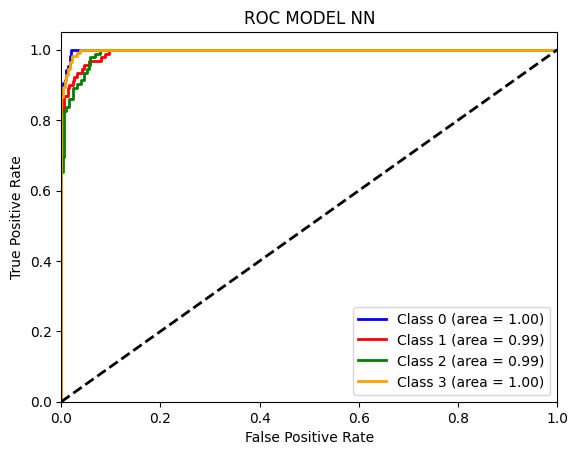

In [33]:
# Plot Kurva ROC
plt.figure()
colors = ['blue', 'red', 'green', 'orange']
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs_nn[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC MODEL NN')
plt.legend(loc='lower right')
plt.show()

# **XGBOOST**

In [34]:
## Mengevaluasi model XGBOOST ##
# Menguji model menggunakan data uji (X_test)
y_pred_xgb = best_xgb.predict(X_test)
# Menghitung metrik evaluasi: akurasi, presisi, recall, dan F1 score
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb, average='weighted')
recall = recall_score(y_test, y_pred_xgb, average='weighted')
f1 = f1_score(y_test, y_pred_xgb, average='weighted')
# Menampilkan metrik evaluasi
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.92
Precision: 0.9205765672538806
Recall: 0.92
F1 Score: 0.9200943060671415


In [35]:
# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix XGBOOST:")
print(cm_xgb)

Confusion Matrix XGBOOST:
[[101   4   0   0]
 [  3  86   2   0]
 [  0   5  80   7]
 [  0   0  11 101]]


In [36]:
# Laporan Klasifikasi (Classification Report)
cr_xgb = classification_report(y_test, y_pred_xgb)
print("\nClassification Report XGBOOST:")
print(cr_xgb)


Classification Report XGBOOST:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       105
           1       0.91      0.95      0.92        91
           2       0.86      0.87      0.86        92
           3       0.94      0.90      0.92       112

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



In [37]:
# Prediksi peluang tiap kelas
y_pred_probs_xgb = best_xgb.predict_proba(X_test)

In [38]:
# Skor ROC untuk kasus multiclass
xgb_roc_auc = roc_auc_score(y_test, y_pred_probs_xgb, multi_class='ovr')
print(f'ROC AUC Score: {xgb_roc_auc}')

ROC AUC Score: 0.9917004382375423


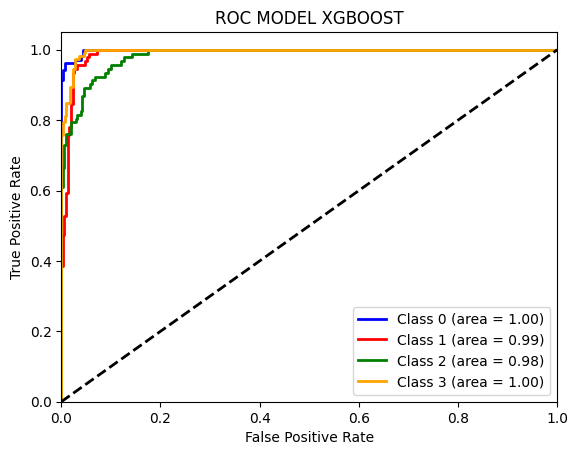

In [39]:
# Menghitung ROC setiap kelas
fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):  # 4 kelas
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_probs_xgb[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot kurva ROC
plt.figure()
colors = ['blue', 'red', 'green', 'orange']
for i in range(4):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC MODEL XGBOOST')
plt.legend(loc="lower right")
plt.show()

# **PREDICTION**

In [40]:
data_testing = pd.read_csv("test.csv")

In [41]:
## Standarisasi data (mean = 0 dan st.dev = 1) ##
# Mendefinisikan fungsi scale data
def scale_data(data_testing):
    # Membuat salinan data
    scaled_data_testing = data_testing.copy()
    # Fitur numerik yang diskalakan
    fitur_numerik = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'talk_time']
    # Melakukan standarisasi
    scaler = StandardScaler()
    # Mengubah skala nilai
    scaled_data_testing[fitur_numerik] = scaler.fit_transform(scaled_data_testing[fitur_numerik])
    return scaled_data_testing
# Menampilkan data hasil standarisasi
scaled_data_testing = scale_data(data_testing)
print(scaled_data_testing)

       id  battery_power  blue  clock_speed  dual_sim        fc  four_g  \
0       1      -0.475451     1     0.312601         1  2.108676       0   
1       2      -0.942782     1    -1.255832         1 -0.132927       1   
2       3       1.292077     1     1.519087         0 -0.805408       0   
3       4       0.688249     0    -1.255832         1  3.005317       1   
4       5       0.429135     0    -0.169994         0  1.436195       1   
..    ...            ...   ...          ...       ...       ...     ...   
995   996       1.044531     1     0.433249         0 -1.029568       1   
996   997      -1.479519     0     0.312601         1 -1.029568       0   
997   998      -0.146932     0    -0.169994         0 -0.805408       1   
998   999       0.658173     1    -1.255832         1 -1.029568       0   
999  1000       0.049718     1    -1.255832         0 -0.132927       1   

     int_memory     m_dep  mobile_wt  ...        pc  px_height  px_width  \
0     -1.581269 -1.4872

# **NEURAL NETWORK**

In [42]:
# Mengonversi dataframe ke dataset TensorFlow
def data_to_dataset(dataframe, batch_size=32):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices(dict(dataframe))
    ds = ds.batch(batch_size)
    return ds

test_ds = data_to_dataset(scaled_data_testing)

In [43]:
# Prediksi menggunakan model NN
y_pred_probs_nn = model.predict(test_ds)
y_pred_nn = tf.argmax(y_pred_probs_nn, axis=1).numpy()

# Menampilkan prediksi
print("Prediksi NN:")
print(y_pred_nn)

32/32 [==============================] - 0s 3ms/step
Prediksi NN:
[3 3 2 3 1 3 3 1 3 0 3 3 0 0 2 0 2 1 3 1 1 3 1 1 3 0 2 0 2 0 2 0 3 0 1 1 3
 1 2 1 1 2 0 0 0 0 0 3 1 2 1 0 3 0 3 0 3 1 0 3 3 2 0 1 0 1 2 3 1 2 1 2 2 3
 3 0 2 0 1 3 0 3 3 0 3 0 3 1 3 0 1 2 2 1 2 2 0 2 1 2 1 0 0 3 0 2 0 1 2 3 3
 2 1 3 3 3 3 2 3 0 0 3 2 1 2 0 3 2 2 2 0 2 1 1 3 1 1 0 3 2 1 2 1 2 2 3 3 2
 2 3 2 3 1 0 2 2 3 3 3 3 3 2 3 3 3 3 1 0 3 0 0 0 2 0 0 1 0 0 1 2 1 0 0 1 1
 2 2 1 0 0 0 1 0 3 2 0 2 2 3 3 1 2 3 3 3 2 2 1 0 0 1 2 0 2 3 3 0 2 0 3 2 3
 3 1 0 1 0 3 0 1 0 2 2 1 2 0 2 0 3 1 2 0 0 2 0 3 3 3 1 1 3 0 0 2 3 3 1 3 1
 1 3 2 1 2 3 3 3 1 0 0 2 3 1 1 3 2 0 3 0 0 2 0 0 3 2 3 3 2 0 3 3 2 3 1 3 1
 2 0 2 3 1 0 0 3 0 3 0 1 2 0 2 3 1 3 2 2 0 2 0 0 0 1 3 2 0 0 0 3 2 0 2 3 0
 2 2 2 3 1 3 3 2 2 2 3 3 0 3 0 3 1 3 1 2 3 0 1 0 3 1 3 2 3 0 0 0 0 2 0 0 2
 2 0 2 2 2 0 1 0 0 3 2 0 3 1 2 2 1 2 3 1 1 2 2 1 2 0 1 1 0 3 2 0 0 1 0 0 1
 1 0 0 0 2 2 3 2 3 0 2 0 3 0 1 1 0 2 0 3 2 3 3 1 3 1 3 1 2 2 0 1 2 1 1 0 0
 0 1 2 1 0 3 2 0 2 2 0 0 3 1 2 1 2

# **XGBOOST**

In [44]:
data_predict = scaled_data_testing[['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']]

In [45]:
data_predict.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,-0.475451,1,0.312601,1,2.108676,0,-1.581269,-1.487247,1.535535,-0.580671,0.976026,-0.926990,0.391912,1.229373,0.001158,7,-1.653355,0,1,0
1,-0.942782,1,-1.255832,1,-0.132927,1,1.509303,1.006341,1.478120,0.293833,0.319433,0.274729,-0.871028,1.614643,-1.388231,0,-0.743418,1,0,0
2,1.292077,1,1.519087,0,-0.805408,0,-0.367116,1.362567,1.334582,-0.580671,-0.993754,1.485693,0.287236,0.236313,1.158982,10,-0.197456,0,1,1
3,0.688249,0,-1.255832,1,3.005317,1,-0.477493,-0.062340,-1.249091,1.605590,1.632619,-0.767532,1.165604,1.612804,-0.461972,0,-0.743418,1,1,0
4,0.429135,0,-0.169994,0,1.436195,1,0.847037,-0.062340,-0.904602,0.731085,1.304323,0.281662,-0.977979,-0.336535,0.695852,8,-0.743418,1,0,1


In [46]:
# Prediksi menggunakan model XGBoost
y_pred_xgb = best_xgb.predict(data_predict)

# Menampilkan prediksi
print("Prediksi XGBoost:")
print(y_pred_xgb)

Prediksi XGBoost:
[3 3 2 3 1 3 3 1 3 0 3 3 0 0 2 0 2 1 3 2 1 3 1 1 3 0 2 0 3 0 2 0 3 0 1 1 3
 1 2 1 1 2 0 0 0 1 0 3 1 2 1 0 2 0 3 1 3 1 1 3 3 2 0 1 1 1 1 3 1 2 1 2 2 3
 3 0 2 0 2 3 1 3 3 0 3 0 3 1 3 0 1 2 2 0 2 2 0 2 1 2 1 0 0 3 0 2 0 1 2 3 3
 2 1 3 3 3 3 2 3 0 0 3 2 1 1 0 3 2 3 1 0 2 1 1 3 1 1 0 3 2 1 2 1 2 2 3 3 2
 2 3 2 3 0 0 3 2 3 3 3 3 2 2 3 3 3 3 1 0 3 0 0 0 1 1 0 1 0 0 1 2 1 0 0 1 2
 2 2 1 0 0 0 1 0 3 2 0 2 2 2 3 1 2 2 2 3 2 2 1 0 0 1 2 0 2 3 3 0 2 0 3 2 3
 3 1 0 1 0 3 0 1 0 2 2 1 3 1 3 0 3 1 2 0 0 2 1 3 2 3 1 1 3 0 0 2 3 3 1 3 1
 1 3 2 1 2 3 3 3 1 0 1 2 3 1 1 3 2 0 3 0 1 2 0 0 3 2 3 3 2 1 3 3 2 3 2 2 1
 2 0 2 3 1 0 0 3 0 3 0 1 2 0 2 3 1 3 2 2 1 2 0 0 0 1 3 2 0 0 0 3 2 0 2 3 1
 2 2 2 3 1 3 3 2 2 2 3 3 0 3 0 3 1 3 1 3 3 0 1 0 3 1 3 2 3 0 0 0 0 2 0 0 2
 2 1 2 2 2 0 1 0 0 3 2 0 3 1 2 2 1 2 3 1 1 2 2 1 2 0 1 1 0 3 2 1 0 1 0 0 1
 1 0 0 0 2 2 3 2 3 0 3 0 3 0 1 1 1 2 0 3 2 3 3 1 3 1 3 1 3 2 1 2 2 1 2 0 0
 0 1 2 1 0 3 2 0 2 2 0 0 3 1 1 0 2 2 3 0 3 0 2 3 2 3 0 2 0 2 2 0 1 2 0 0 1
 1 1 3 